In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython import display

C:\Users\s381731\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


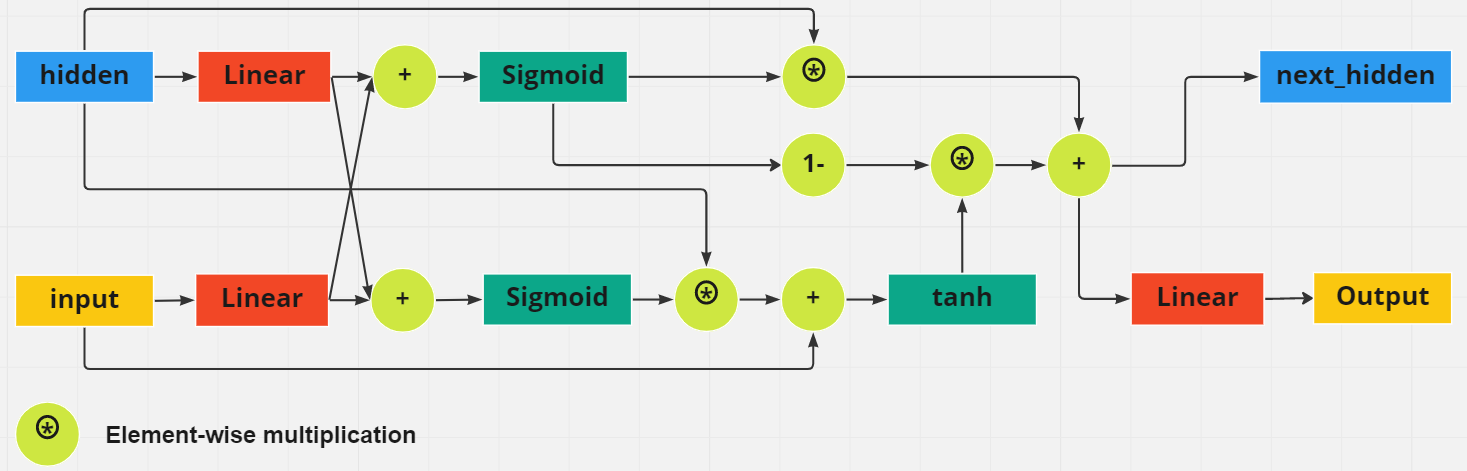

In [3]:
display.Image('imgs/gru_cell.PNG')

In [4]:
class GRUNet(nn.Module):
    """ Define the GRU model """

    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2) -> None:
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.linear(out[:, -1]) # Only use the final output from the GRU model
        out = self.relu(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden